MOVE STUFF HERE FROM skillcornerSmooth.ipynb

In [201]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline
from mplsoccer.pitch import Pitch
import json
import pandas as pd
import re
from math import isnan, sqrt
from datetime import datetime, timedelta
from smoothing import performSmoothing, euclidianDistance

In [202]:
import csv

def read_csv_partially(file_path, start_line, end_line):
    data = []  # List to store extracted CSV rows

    with open(file_path, 'r', newline='') as file:
        reader = csv.reader(file)
        for line_num, row in enumerate(reader):
            if line_num >= start_line and line_num <= end_line:
                # Append the row to data
                data.append(row)
            elif line_num > end_line:
                break  # Stop reading once end_line is reached

    return data

In [203]:
def plotMovement(playerID, df, start_frame=34591, end_frame=34764):

    pitch = Pitch(pitch_type='skillcorner', axis=True, label=True,
                  pitch_length=105, pitch_width=68,
                  pitch_color='white', line_color='black',)

    df = df[df['object_id'] == playerID].copy().reset_index()

    fig, ax = pitch.draw(figsize=(20, 16), constrained_layout=True, tight_layout=False)
    window = [60,-60,60,-60]
    for i, frame in df.iterrows():
        # for i in range(1, len(frame)):
        if frame['frame_id'] >= start_frame and frame['frame_id'] <= end_frame:
            x = float(frame['x'])
            y = float(frame['y'])
            window = [min(x, window[0]), max(x, window[1]), min(y, window[2]), max(y, window[3])]

            if isnan(x) or isnan(y):
                continue
            ax.plot(x, y, 'ro', markersize=10, color='blue')
            if i > 1:
                x_prev = float(df.loc[i-1, 'x'])
                y_prev = float(df.loc[i-1, 'y'])
                if isnan(x_prev) or isnan(y_prev):
                    continue
                ax.plot([x_prev, x], [y_prev, y], 'r-', linewidth=2)
                ax.arrow(x_prev, y_prev, x - x_prev, y - y_prev, color='r', head_width=0.2, head_length=0.4)
    
    ax.set_xlim([window[0]-5, window[1]+5])
    ax.set_ylim([window[2]-5, window[3]+5])
    plt.show()

In [204]:
file_path_skillcorner = '../data/matches/Feb/1384039_tracking.csv'
lineup_path = '../data/matches/Feb/1384039_lineup.csv'
partialframes = read_csv_partially(file_path_skillcorner, 0, 1500000)

lineup = read_csv_partially(lineup_path, 0, 33)
# targetIDSkillcorner = 7679
targetIDSkillcorner = 10218
targetPositionsSkillcorner = []

def getTrajectories(teamName, lineup, partialframes):
    playerIDs = set()
    teamName = "FC Basel"

    for player in list(filter(lambda player: player[1] == teamName, lineup[1:])):
        playerIDs.add(str(player[2]))

    targetTrajs = {}
    playerSmoothDataFrames = pd.DataFrame()
    for ID in playerIDs:
        targetTrajs[ID] = []
        playerSmoothDataFrames = pd.DataFrame()

    for index, playerFrame in enumerate(partialframes):

        if(playerFrame[4] not in playerIDs or playerFrame[8] == 'True'):
            continue

        # defining datapoints d_i = [x_Coordinate, y_Coordinate, speed, time]
        if targetTrajs[playerFrame[4]] == [] or int(targetTrajs[playerFrame[4]][-1][-1][-1]) != (int(playerFrame[2]) - 1):
            targetTrajs[playerFrame[4]].append([])
            
        targetTrajs[playerFrame[4]][-1].append([float(playerFrame[5]), float(playerFrame[6]), 0, datetime.fromtimestamp(int(playerFrame[3])/1000.0), int(playerFrame[2])])
    return targetTrajs

targetTrajs = getTrajectories("FC Basel", lineup, partialframes)

<h1>Time Series Analysis<h1>

<h3>Speed Smoothing</h3>

In [205]:
isolatedTraj = []
for player, trajs in targetTrajs.items():
    for traj in trajs:
        if len(traj) >= 718:
            isolatedTraj = traj
            break

# Leon Avdullahu
# broke = False
# for player, trajs in targetTrajs.items():
#     for(trajectory) in trajs:
#         if trajectory[0][-1] >= 60960 and trajectory[0][-1] <= 60980:
#             isolatedTraj = trajectory
#             broke = True
#             print(trajectory)
#             break
#     if broke:
#         break

# print(isolatedTraj)
smoothIsolatedTrajs = [
    performSmoothing(isolatedTraj, 1),
    performSmoothing(isolatedTraj, 5),
    performSmoothing(isolatedTraj, 10),
    performSmoothing(isolatedTraj, 50),
    performSmoothing(isolatedTraj, 100),
    performSmoothing(isolatedTraj, 150),
    performSmoothing(isolatedTraj, 200),
    performSmoothing(isolatedTraj, 400),
    performSmoothing(isolatedTraj, 600)
]

its = [
    1,
    5,
    10,
    50,
    100,
    150,
    200,
    400,
    600,
]
isolatedTraj = pd.DataFrame(isolatedTraj)


**Add Gaussian Filtering on Frecquency Domain of Speed signal**

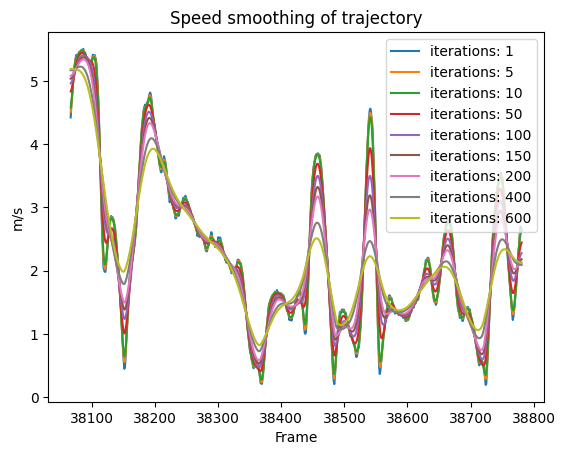

In [206]:
# plot the speed timeseries 
smoothIsolatedTrajsDFs = []
for i, traj in enumerate(smoothIsolatedTrajs):
    # if(i == 2):
    #     continue
    traj = pd.DataFrame(traj)
    
    traj.columns = ['x', 'y', 'speed', 'time', 'frame_id']
    traj['frame_id'] = isolatedTraj[4]
    traj['frame_id'] = traj['frame_id'].astype(int)
    smoothIsolatedTrajsDFs.append(traj)
    plt.plot(traj.loc[:, 'frame_id'][1:-1], (traj.loc[:, 'speed'][1:-1]*10), color='C'+str(i), label='iterations: ' + str(its[i]))

plt.title('Speed smoothing of trajectory')
plt.xlabel('Frame')  # Replace 'Index' with the actual x-axis label
plt.ylabel('m/s')  # Replace 'Value' with the actual y-axis label
plt.legend()
# plt.xlim(38222, 38335)
plt.show()

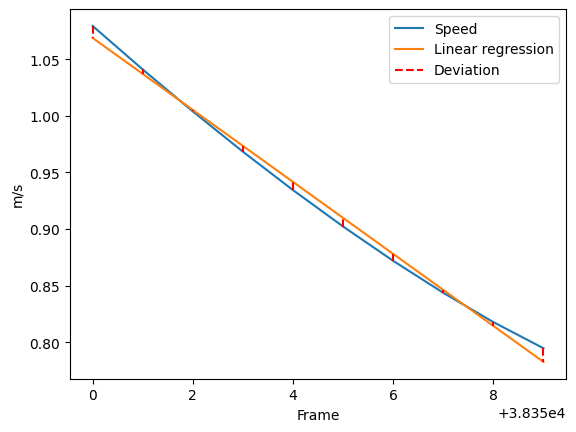

0.006817260480429391


In [220]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

speedTS = pd.DataFrame(smoothIsolatedTrajs[7])
speedTS[2] = speedTS[2]*10
speedTS.columns = ['x', 'y', 'speed', 'time', 'frame_id']
speedTS['frame_id'] = isolatedTraj[4]
speedTS = speedTS[1:-1]
speedTS = speedTS[['speed', 'frame_id']]
speedTS = speedTS[(speedTS['frame_id'] >= 38350) & (speedTS['frame_id'] < 38360)]

lr.fit(speedTS[['frame_id']], speedTS['speed'])

slope = lr.coef_[0]
intercept = lr.intercept_

speedTS['linear'] = lr.predict(speedTS[['frame_id']])
speedTS['deviation'] = (speedTS['speed'] - speedTS['linear'])**2

plt.plot(speedTS['frame_id'], speedTS['speed'], label='Speed')
plt.plot(speedTS['frame_id'], speedTS['linear'], label='Linear regression')

count = 0
for _, row in speedTS.iterrows():
    if count == 0:
        plt.plot([row['frame_id'], row['frame_id']], [row['speed'], row['linear']], color='r', linestyle='--', label='Deviation')
    else:
        plt.plot([row['frame_id'], row['frame_id']], [row['speed'], row['linear']], color='r', linestyle='--')
    count += 1

plt.xlabel('Frame')  # Replace 'Index' with the actual x-axis label
plt.ylabel('m/s')  # Replace 'Value' with the actual y-axis label
plt.legend()
plt.show()

print(sqrt(speedTS['deviation'].sum()/len(speedTS)))

In [208]:
def getSpeedDeviationHelper(trajectory):
    lr = LinearRegression()

    speedTS = trajectory.copy()
    speedTS = speedTS[['speed', 'frame_id']]

    lr.fit(speedTS[['frame_id']], speedTS['speed'])

    speedTS['linear'] = lr.predict(speedTS[['frame_id']])
    speedTS['deviation'] = (speedTS['speed'] - speedTS['linear'])**2

    return sqrt(speedTS['deviation'].sum()/len(speedTS))

In [209]:
def getSpeedDeviation(trajectory):
    trajectory = pd.DataFrame(trajectory)
    trajectory.columns = ['x', 'y', 'speed', 'time', 'frame_id']
    totalSD = 0
    for i in range(len(trajectory)//10):
        partition = trajectory.iloc[i*10:(i+1)*10, :].copy()
        totalSD += getSpeedDeviationHelper(partition)

    return totalSD/(len(trajectory)//10)

print(getSpeedDeviation(smoothIsolatedTrajsDFs[6]))

0.003001943289689807


<h1>Trajectory Similarity</h1>

In [210]:
traj1 = list(map(lambda x: [x[0], x[1]], smoothIsolatedTrajs[0]))
traj2 = list(map(lambda x: [x[0], x[1]], smoothIsolatedTrajs[1]))

<h3>Dynamic Time Warping</h3>

Using: https://dtaidistance.readthedocs.io/en/latest/

In [211]:
import dtaidistance
from dtaidistance import dtw_ndim

series1 = np.array(traj1, dtype=np.double)
series2 = np.array(traj2, dtype=np.double)
d = dtw_ndim.distance(series1, series2)

Dmatrix = dtaidistance.dtw_ndim.distance_matrix(series1, series2)
d, paths = dtaidistance.dtw_ndim.warping_paths(series1, series2)
print(d)

0.2850909634734277


In [212]:
from dtaidistance import dtw_visualisation
dtw_visualisation.plot_warpingpaths(series1, series2, paths, filename="warp.png")

(None, None)

<h3>Lock-Step Distance<h3>

In [213]:
series1 = np.array(traj1, dtype=np.double)
series2 = np.array(traj2, dtype=np.double)

assert(len(series1) == len(series2))
totalDistance = 0
for (x, y) in zip(series1, series2):
    totalDistance += euclidianDistance(x, y)

print(totalDistance)

5.417388083896601


<h3>Fréchet Distance</h3>

Using: https://pypi.org/project/frechetdist/

In [214]:
import frechetdist

series1 = np.array(traj1, dtype=np.double)
series2 = np.array(traj2, dtype=np.double)

print(frechetdist.frdist(series1, series2))

0.04254990616222426


- check gps trajectory data to use as "true" reference
- add noise, experiments, longitudinal and lateral noise

In [215]:
SD = []
d = []
for i, traj in enumerate(smoothIsolatedTrajsDFs[1:]):
    SD.append(getSpeedDeviation(traj))

    series1 = np.array(traj[['speed', 'frame_id']], dtype=np.double)
    series2 = np.array(smoothIsolatedTrajsDFs[0][['speed', 'frame_id']], dtype=np.double)
    distance = dtw_ndim.distance(series1, series2)
    d.append(dtw_ndim.distance(series1, series2))
    print(distance)


0.07854019160997379
0.1367111339532822
0.47706115272379496
0.7448802817776388
0.9315489018810075
1.0713614359216947
1.4084206227050067
1.5967826683982163


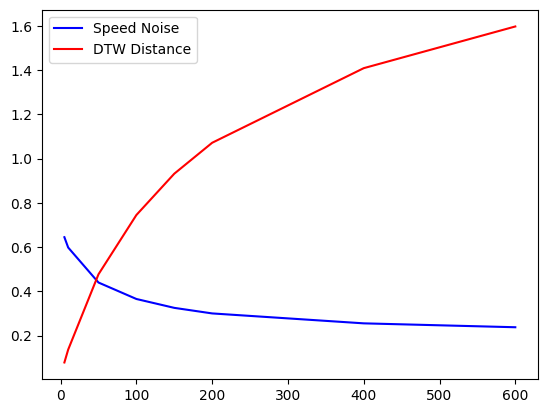

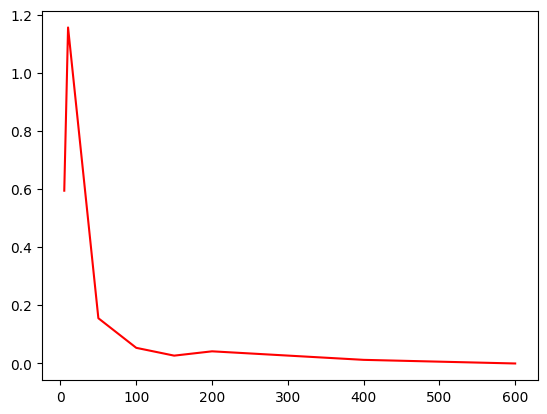

In [265]:
import math
SDcopy = SD.copy()
for idx, S in enumerate(SDcopy):
    SDcopy[idx] *= 100
plt.plot(its[1:], SDcopy, color='blue', label='Speed Noise')
plt.plot(its[1:], d, color='red', label='DTW Distance')
plt.legend()
plt.show()

ratios = []
for i, sd in enumerate(SDcopy):
    # ratios.append(1/(sd*d[i]))
    if(i == len(SDcopy) - 1):
        ratios.append(0)
        break
    # ratios.append(math.sqrt((SDcopy[i+1] - SDcopy[i])**2)/math.sqrt((d[i+1] - d[i])**2))
    ratios.append((SDcopy[i] - SDcopy[i+1])/d[i])

plt.plot(its[1:], ratios, color='red', label='DTW Distance')
plt.show()

Conclusion from plots:
- Around 50-100 iterations yields the best smoothing without changing the original trajectory too much